In [1]:
import os 
import tensorflow as tf
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Layer, Dense, Input, Conv2D, MaxPooling2D, Flatten, LeakyReLU, Add, Concatenate, LSTM, Dropout, Reshape, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model



In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Enable memory growth for the first (and only) GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Memory growth enabled for {gpus[0]}")
    except RuntimeError as e:
        print(e)  # This happens if GPUs are initialized before setting memory growth
else:
    print("No GPU found. Running on CPU.")

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## P1.1 ###

In this section I implement the shallow parallel CNN architecture, according to the instructions. I chose a stochastic minibatch gradient descent algorithm with momentum ($\gamma$ = 0.9), in order to accelerate convergence. Finally, I plot the loss and accuracy over epochs, both for training and validation set. From the first plot we see that although the model achieves very high accuracy on the training set, it does not generalize the same on validation dataset (overfitting), although accuracy is high there as well (~70%). We can also see a similar pattern, from the second plot. The training loss is constantly getting lower, while validation loss is getting higher after a point, an indication of overfitting.

In [5]:
# Read train and validation datasets
train_dataset = tf.data.Dataset.load('ST456_assignment2/assign2_train')
validation_dataset = tf.data.Dataset.load('ST456_assignment2/assign2_val')

# Batch datasets
batch_size = 128
train_dataset_batch = train_dataset.batch(batch_size)
validation_dataset_batch = validation_dataset.batch(batch_size)



In [4]:
# Model Building
input_shared = Input(shape=(80,80,1))
x = Conv2D(filters=3, kernel_size=(8,8), padding='valid', activation = LeakyReLU(alpha=0.3))(input_shared)
x = MaxPooling2D(pool_size=(4,4))(x)
output_1 = Flatten()(x)

y = Conv2D(filters=4, kernel_size=(4,4), padding = 'valid', activation = LeakyReLU(alpha=0.3))(input_shared)
y = MaxPooling2D()(y)
output_2 = Flatten()(y)

concat_layer = Concatenate()([output_1,output_2])
dense_layer = Dense(8, activation='softmax')(concat_layer)

model =  Model(inputs = input_shared, outputs = dense_layer)

model.summary()

# Model Compiling
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 73, 73, 3)    195         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 77, 77, 4)    68          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 18, 18, 3)    0           ['conv2d[0][0]']                 
                                                                                              

In [5]:
# Model training
epochs = 50

history = model.fit(train_dataset_batch, validation_data=validation_dataset_batch, epochs=epochs, verbose=0)


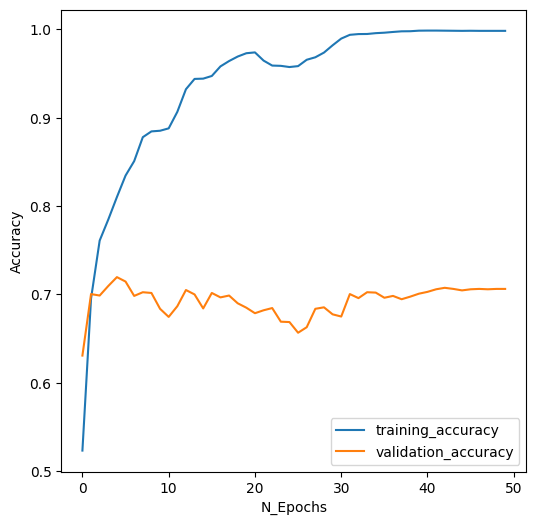

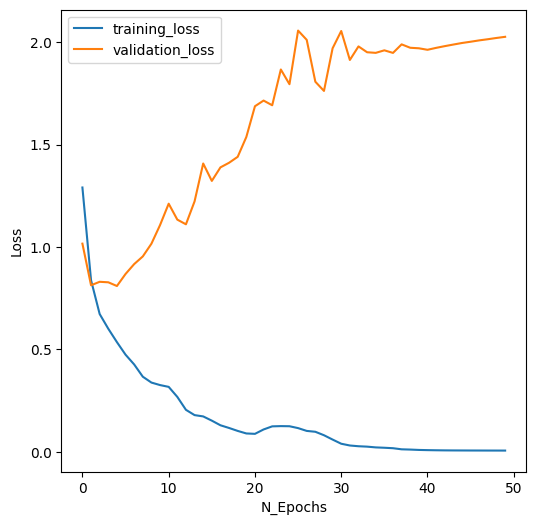

In [6]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('N_Epochs')
plt.legend()


plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.ylabel('Loss')
plt.xlabel('N_Epochs')
plt.legend()

## P1.2 ##

In the following, I implement the CNN-RNN architecture according to the instructions. One thing to note is that before adding the first LSTM layer, I reshaped the CNN output to 324x6. The CNN output tensor was of dimension [18,18,6], so my intuition was that the number of channels (6) should be the features and time and frequency (18x18) the rows, since the goal of an RNN here would be to learn about the evolution of time-frequency characteristics over-time in order to further refine the information grasped by the CNN. Finally, I plot the loss and accuracy over epochs both for training and validation set. From both the plots we can see that the model performs great both in training and validation data since accuracy is constantly increasing in both and loss is constantly decreasing in both. Also, there is not a significant discrepancy between the two sets indicating effective avoidance of overfitting. 

In [6]:
def reduce_dimension(x, y):

  return tf.squeeze(x, axis=-1), y

# Reduce Dimension
train_dataset_squeeze = train_dataset.map(reduce_dimension)
validation_dataset_squeeze = validation_dataset.map(reduce_dimension)

# Batch Datasets
train_dataset_squeeze_batch = train_dataset_squeeze.batch(batch_size)
validation_dataset_squeeze_batch = validation_dataset_squeeze.batch(batch_size)


In [8]:
# Model Building
input = Input(shape=(80,80,1))
x = Conv2D(filters = 8, kernel_size = (4,4))(input)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(filters = 6, kernel_size = (3,3))(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Reshape((324,6))(x) 
x = LSTM(128, return_sequences=True)(x)
x = LSTM(32)(x)
x = Dense(200, activation = 'relu')(x)
x = Dropout(0.2)(x)
output = Dense(8, activation='softmax')(x)

model_2 = Model(input,output)
model_2.summary()

# Model compiling
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'],optimizer=tf.keras.optimizers.SGD(momentum=0.9))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 77, 77, 8)         136       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 38, 38, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 36, 6)         438       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 6)        0         
 2D)                                                             
                                                                 
 reshape (Reshape)           (None, 324, 6)            0   

In [9]:
# Training
history_2 = model_2.fit(train_dataset_squeeze_batch, 
                        validation_data=validation_dataset_squeeze_batch, 
                        epochs=50, verbose=0)

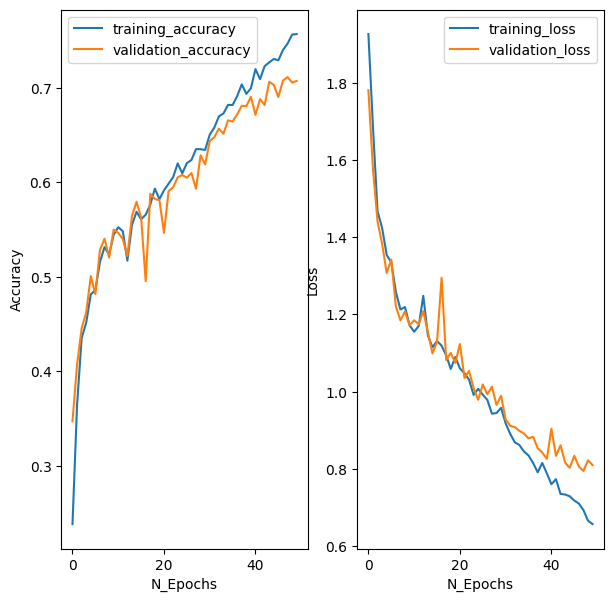

In [10]:
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(history_2.history['accuracy'], label='training_accuracy')
plt.plot(history_2.history['val_accuracy'], label='validation_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('N_Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_2.history['loss'], label='training_loss')
plt.plot(history_2.history['val_loss'], label='validation_loss')
plt.ylabel('Loss')
plt.xlabel('N_Epochs')
plt.legend()

## P2 ##

In the following code I implement a model that achieves at least 85% validation accuracy. Basically, I started from the model of P1.2 and added some modifications. Initially, I used batch normalization in each convolutional block in order to stabilize updates and speed-up convergence. In addition, I included a leaky RELU activation in each block, (like in P1.1) since the spectograms are log-transformed and thus there may be a lot of negative values resulting in dead neurons (0) if ordinary RELU is applied. Also, I added padding in order to maintain the spatial dimensions in each block, and thus gradually increase the receptive field, while maintaining on the same time more information (for example the output of the second convolutional block is [20,20,6], as opposed to [18,18,6] from before). However, the most important changes were the following: first, I reshaped the output of the second convolutional block as 100x24 instead of theoretically 400x6. I did that in order to have a richer representation for each time-frequency observation (in other words for each step), and make the LSTM's capture more complex patterns in each step. Second, I used biderictional LSTM's, intuitively in order to grasp more context both from past and future time steps. Finally, I slightly increased the dropout rate at 0.3 to avoid overfitting, and used and adam optimizer, since it is more preferable for deeper networks like this one, and also performed better than other optimizers. As for the results plotted, although there is some amount of overfitting, it doesn't pose a problem since the validation accuracy is approximately 87%. The same applies for validation loss, which is the smallest compared with all the other implemented models so far.  

In [7]:
input = Input(shape=(80, 80, 1))

x = Conv2D(8, (4, 4), padding='same')(input)
x = BatchNormalization()(x)
x = LeakyReLU(0.3)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(6, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.3)(x)
x = MaxPooling2D((2, 2))(x)

# reshape: richer features
x = Reshape((100, 24))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(32))(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)
model = Model(input, output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [8]:
# training

history_3 = model.fit(train_dataset_squeeze_batch, 
                        validation_data=validation_dataset_squeeze_batch, 
                        epochs=50, verbose = 0)

In [ ]:
# Validation accuracy
loss, acc = model.evaluate(validation_dataset_squeeze_batch)
print(acc)

19/19 [==============================] - 1s 23ms/step - loss: 0.6019 - accuracy: 0.8704
0.8704166412353516


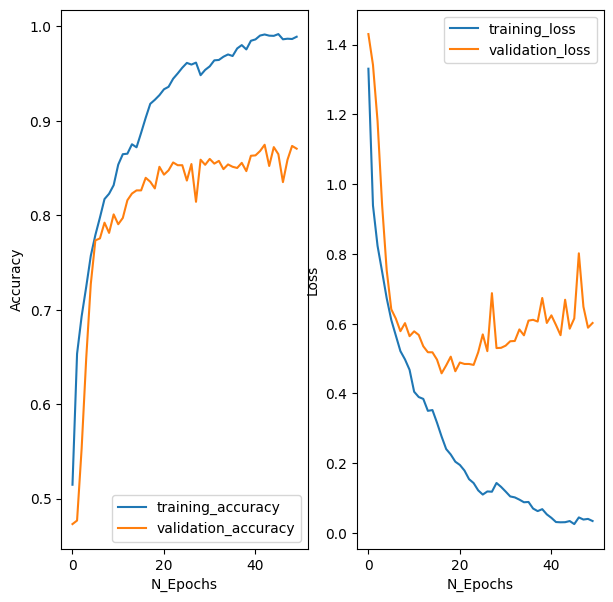

In [12]:
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(history_3.history['accuracy'], label='training_accuracy')
plt.plot(history_3.history['val_accuracy'], label='validation_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('N_Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_3.history['loss'], label='training_loss')
plt.plot(history_3.history['val_loss'], label='validation_loss')
plt.ylabel('Loss')
plt.xlabel('N_Epochs')
plt.legend()